In [ ]:
!conda install -c conda-forge opencv
!pip install tqdm
!pip install -U albumentations
!pip install efficientnet_pytorch
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - 

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os, random, time, copy
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import albumentations as A
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score 
from efficientnet_pytorch import EfficientNet
import cv2
import re
%matplotlib inline

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [53]:
train = pd.read_csv('./input/data/train/train.csv')

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


In [55]:
train.describe(include='all')

,id,gender,race,age,path
count,2700,2700,2700,2700.000000,2700
unique,2699,2,1,NaN,2700
top,003397,female,Asian,NaN,000001_female_Asian_45
freq,2,1658,2700,NaN,1
mean,NaN,NaN,NaN,37.708148,NaN
std,NaN,NaN,NaN,16.985904,NaN
min,NaN,NaN,NaN,18.000000,NaN
25%,NaN,NaN,NaN,20.000000,NaN
50%,NaN,NaN,NaN,36.000000,NaN
75%,NaN,NaN,NaN,55.000000,NaN


In [56]:
def age(x):
  if x<30:
    return 0
  elif x<60:
    return 1
  else:
    return 2

# age: <30: 0, >=30, <60: 1, >=60: 2
train['age'] = train['age'].apply(lambda x: age(x))

# gender: female: 0, male: 1
train['gender'] = train['gender'].map({'female': 0, 'male': 1})

train = train.drop(['race'], axis=1)
train

,id,gender,age,path
0,000001,0,1,000001_female_Asian_45
1,000002,0,1,000002_female_Asian_52
2,000004,1,1,000004_male_Asian_54
3,000005,0,1,000005_female_Asian_58
4,000006,0,1,000006_female_Asian_59
...,...,...,...,...
2695,006954,1,0,006954_male_Asian_19
2696,006955,1,0,006955_male_Asian_19
2697,006956,1,0,006956_male_Asian_19
2698,006957,1,0,006957_male_Asian_20


In [57]:
# print(train.iloc[:])

In [58]:
for i in range(len(train)):
    if train.iloc[i, 3] in ['004432_male_Asian_43','001498-1_male_Asian_23']:
        train.iloc[i, 1] = 0
        print(train.iloc[i])
    elif train.iloc[i, 3] in ['006359_female_Asian_18','006360_female_Asian_18',
                              '006361_female_Asian_18','006362_female_Asian_18',
                              '006363_female_Asian_18','006364_female_Asian_18']:
        train.iloc[i, 1] = 1
        print(train.iloc[i])

id                      001498-1
gender                         0
age                            0
path      001498-1_male_Asian_23
Name: 764, dtype: object
id                      004432
gender                       0
age                          1
path      004432_male_Asian_43
Name: 1912, dtype: object
id                        006359
gender                         1
age                            0
path      006359_female_Asian_18
Name: 2399, dtype: object
id                        006360
gender                         1
age                            0
path      006360_female_Asian_18
Name: 2400, dtype: object
id                        006361
gender                         1
age                            0
path      006361_female_Asian_18
Name: 2401, dtype: object
id                        006362
gender                         1
age                            0
path      006362_female_Asian_18
Name: 2402, dtype: object
id                        006363
gender                      

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   int64 
 2   age     2700 non-null   int64 
 3   path    2700 non-null   object
dtypes: int64(2), object(2)
memory usage: 84.5+ KB


<Figure size 1200x800 with 0 Axes>

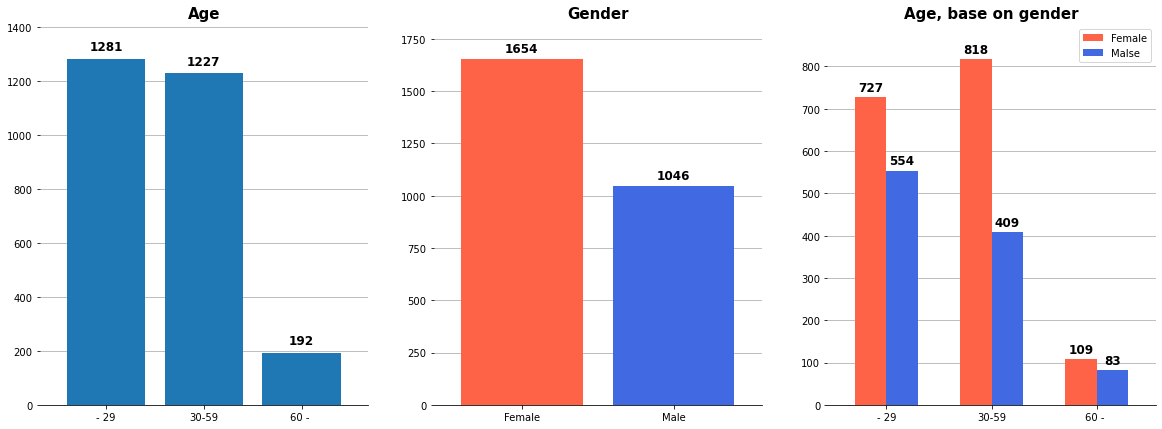

In [60]:
age_label = train['age'].value_counts().sort_index()
gender_label = train['gender'].value_counts().sort_index()
age_gender = train.groupby('gender')['age'].value_counts().sort_index()

plt.figure(dpi=200)
fig = plt.figure(figsize=(20, 7))

idx = np.arange(len(age_gender[0].index))
width=0.3

ax_age = fig.add_subplot(1, 3, 1)
ax_gender = fig.add_subplot(1, 3, 2)
ax_base = fig.add_subplot(1, 3, 3)


# Age
ax_age.bar(age_label.index, age_label, zorder=10)
    
for index, val in age_label.iteritems():
    ax_age.text(x=index, y=val+20, s=val,
                 va='bottom', ha='center',
                 fontsize=12, fontweight='bold'
                )

# Gender
ax_gender.bar(['Female', 'Male'],gender_label, color=['tomato', 'royalblue'], zorder=10)

for index, value in zip(gender_label.index, gender_label):
    ax_gender.text(index, value+20, s=value,
                   va='bottom', ha='center',
                   fontsize=12, fontweight='bold'
                  )

# Age, base on gender
for i in range(2):
    ax_base.bar(idx-width/2 if i ==0 else idx+width/2, age_gender[i], 
                color='tomato' if i==0 else 'royalblue',
                label='Female' if i==0 else 'Malse',
                width=width, zorder=10
               )

for i in range(2):
    for index, val in age_gender[i].iteritems():
        list_idx = [index-0.15, index+0.15]
        ax_base.text(x=list_idx[i], y=val+7, s=val,
                    va='bottom', ha= 'center',
                    fontsize=12, fontweight='bold'
                    )


list_ages = ['- 29', '30-59', '60 - ']
    
ax_age.margins(0.1, 0.1)
ax_age.set_xticks(idx)
ax_age.set_xticklabels(list_ages)
ax_age.set_title('Age', fontsize=15, fontweight='bold')
ax_age.grid(zorder=0, axis='y')
    
ax_gender.margins(0.1, 0.1)
ax_gender.set_title('Gender', fontsize=15, fontweight='bold')
ax_gender.grid(zorder=0, axis='y')
    
ax_base.margins(0.1, 0.1)
ax_base.set_xticks(idx)
ax_base.set_xticklabels(list_ages)
ax_base.set_title('Age, base on gender', fontsize=15, fontweight='bold')
ax_base.grid(zorder=0, axis='y')
ax_base.legend()

for s in ['top', 'right', 'left']:
    ax_age.spines[s].set_visible(False)
    ax_gender.spines[s].set_visible(False)
    ax_base.spines[s].set_visible(False)

        
plt.show()

In [61]:
def prepare_mask_data(data_path):
    name = set()
    data = {'path': [], 'mask': []}
    cnt = 0

    for labels in os.listdir(data_path):
        label = None
        if labels[:2]=='._': continue
        sub = os.path.join(data_path, labels)
        cnt += 1
        
        # mask: normal: 0, incorrect: 1, mask: 2
        for img in os.listdir(sub):
            if img[0]=='.':continue
            if img.find('normal') != -1:
                label = 0
            elif img.find('incorrect') != -1:
                label = 1
            else:
                label = 2
            data['path'].append(os.path.join(sub, img))
            data['mask'].append(label)
    
    return pd.DataFrame(data), cnt

In [62]:
data, cnt = prepare_mask_data('./input/data/train/images')
data.info()
print(f'cnt: {cnt}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    18900 non-null  object
 1   mask    18900 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 295.4+ KB
cnt: 2700


In [63]:
data

,path,mask
0,./input/data/train/images/006383_male_Asian_19...,2
1,./input/data/train/images/006383_male_Asian_19...,2
2,./input/data/train/images/006383_male_Asian_19...,2
3,./input/data/train/images/006383_male_Asian_19...,2
4,./input/data/train/images/006383_male_Asian_19...,1
...,...,...
18895,./input/data/train/images/003130_female_Asian_...,2
18896,./input/data/train/images/003130_female_Asian_...,2
18897,./input/data/train/images/003130_female_Asian_...,1
18898,./input/data/train/images/003130_female_Asian_...,0


In [64]:
url = './input/data/train/images/'

for i in range(len(data)):
    if data.iloc[i,0] in [url+'000020_female_Asian_50/normal.jpg',
                          url+'004418_male_Asian_20/normal.jpg',
                          url+'005227_male_Asian_22/normal.jpg']:
            data.iloc[i,1] = 0
            print(data.iloc[i, 0])
            print(data.iloc[i])
    elif data.iloc[i,0] in [url+'000020_female_Asian_50/incorrect_mask.jpg',
                            url+'004418_male_Asian_20/incorrect_mask.jpg',
                            url+'005227_male_Asian_22/incorrect_mask.jpg']:
            data.iloc[i,1] = 1
            print(data.iloc[i, 0])
            print(data.iloc[i])

./input/data/train/images/004418_male_Asian_20/incorrect_mask.jpg
path    ./input/data/train/images/004418_male_Asian_20...
mask                                                    1
Name: 221, dtype: object
./input/data/train/images/004418_male_Asian_20/normal.jpg
path    ./input/data/train/images/004418_male_Asian_20...
mask                                                    0
Name: 222, dtype: object
./input/data/train/images/000020_female_Asian_50/incorrect_mask.jpg
path    ./input/data/train/images/000020_female_Asian_...
mask                                                    1
Name: 1607, dtype: object
./input/data/train/images/000020_female_Asian_50/normal.jpg
path    ./input/data/train/images/000020_female_Asian_...
mask                                                    0
Name: 1608, dtype: object
./input/data/train/images/005227_male_Asian_22/incorrect_mask.jpg
path    ./input/data/train/images/005227_male_Asian_22...
mask                                                    1


In [65]:
def prepare_age_gender_data(data):
    tmp = {'age': [], 'gender': []}

    for index, i in enumerate(data.iloc[:, 0].values):
        classes = i.split('/')[-2]
#         print(classes)
        for idx in train.values:
#             print(idx[3])
            if classes == idx[3]:
                tmp['gender'].append(idx[1])
                tmp['age'].append(idx[2])
                
    return pd.DataFrame(tmp)

In [66]:
labels = prepare_age_gender_data(data)

In [67]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     18900 non-null  int64
 1   gender  18900 non-null  int64
dtypes: int64(2)
memory usage: 295.4 KB


In [68]:
data = pd.concat([data, labels['age'], labels['gender']], axis=1)

In [69]:
len(data)

18900

<Figure size 1200x800 with 0 Axes>

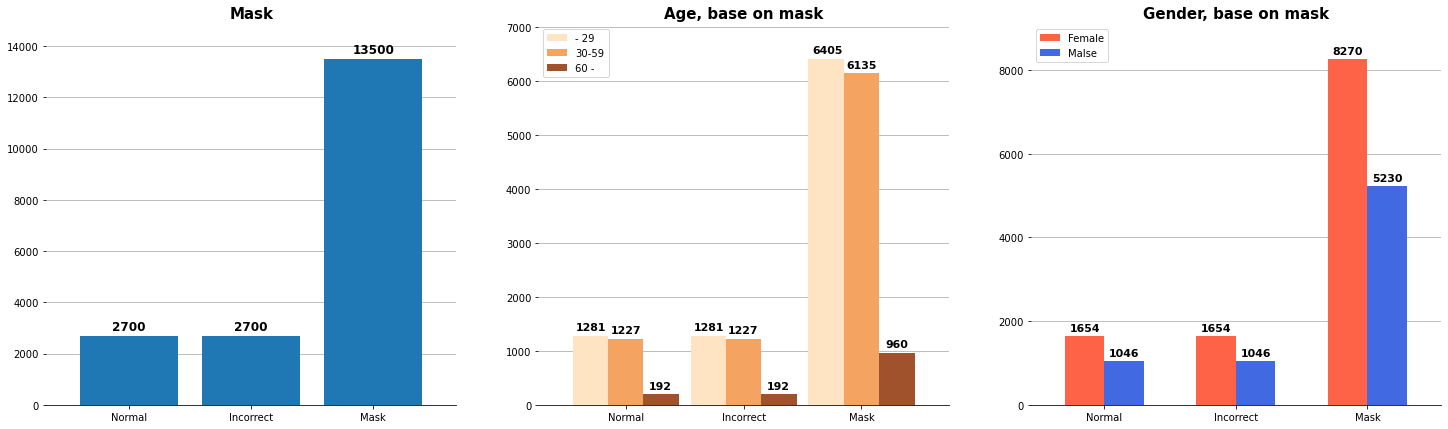

In [70]:
mask_label = data['mask'].value_counts().sort_index()
mask_age = data.groupby('age')['mask'].value_counts().sort_index()
mask_gender = data.groupby('gender')['mask'].value_counts().sort_index()
group_mask = sorted(data['mask'].unique())
group_age = data['age'].unique()

plt.figure(dpi=200)
fig = plt.figure(figsize=(25, 7))

idx = np.arange(len(mask_age[0].index))

ax_mask = fig.add_subplot(1, 3, 1)
ax_age = fig.add_subplot(1, 3, 2)
ax_gender = fig.add_subplot(1, 3, 3)


# Mask
ax_mask.bar(mask_label.index, mask_label, zorder=10)
    
for index, val in mask_label.iteritems():
    ax_mask.text(x=index, y=val+100, s=val,
                 va='bottom', ha='center',
                 fontsize=12, fontweight='bold'
                )

    
# Age, base on mask
age_width = 0.3

for index, g in enumerate(group_age):
    list_ages = ['- 29', '30-59', '60 - ']
    list_colors = ['bisque', 'sandybrown', 'sienna']
    ax_age.bar(idx+(-len(group_age)+2*index)*width/2+0.15, mask_age[g],
              width=age_width, label=list_ages[g], color=list_colors[g], zorder=10)

for i in range(3):
    for index, val in mask_age[i].iteritems():
        list_idx = [index-0.42, index-0.13, index+0.2]
        ax_age.text(x=list_idx[i], y=val+70, s=val,
                     va='bottom', fontsize=11, fontweight='bold'
                    )
    
    
# Gender, base on mask
wdith = 0.3

for i in range(2):
    ax_gender.bar(idx-width/2 if i ==0 else idx+width/2, mask_gender[i], 
                color='tomato' if i==0 else 'royalblue',
                label='Female' if i==0 else 'Malse',
                width=width, zorder=10
               )
    
for i in range(2):
    for index, val in mask_gender[i].iteritems():
        list_idx = [index-0.15, index+0.15]
        ax_gender.text(x=list_idx[i], y=val+70, s=val,
                    va='bottom', ha= 'center',
                    fontsize=11, fontweight='bold')

    
list_ages = ['Normal', 'Incorrect', 'Mask']
    
ax_mask.margins(0.1, 0.1)
ax_mask.set_xticks(idx)
ax_mask.set_xticklabels(list_ages)
ax_mask.set_title('Mask', fontsize=15, fontweight='bold')
ax_mask.grid(zorder=0, axis='y')
    
ax_age.margins(0.1, 0.1)
ax_age.set_xticks(idx)
ax_age.set_xticklabels(list_ages)
ax_age.set_title('Age, base on mask', fontsize=15, fontweight='bold')
ax_age.grid(zorder=0, axis='y')
ax_age.legend()

ax_gender.margins(0.1, 0.1)
ax_gender.set_xticks(idx)
ax_gender.set_xticklabels(list_ages)
ax_gender.set_title('Gender, base on mask', fontsize=15, fontweight='bold')
ax_gender.grid(zorder=0, axis='y')
ax_gender.legend()

for s in ['top', 'right', 'left']:
    ax_mask.spines[s].set_visible(False)
    ax_age.spines[s].set_visible(False)
    ax_gender.spines[s].set_visible(False)
    

plt.show()

In [71]:
data

,path,mask,age,gender
0,./input/data/train/images/006383_male_Asian_19...,2,0,1
1,./input/data/train/images/006383_male_Asian_19...,2,0,1
2,./input/data/train/images/006383_male_Asian_19...,2,0,1
3,./input/data/train/images/006383_male_Asian_19...,2,0,1
4,./input/data/train/images/006383_male_Asian_19...,1,0,1
...,...,...,...,...
18895,./input/data/train/images/003130_female_Asian_...,2,0,0
18896,./input/data/train/images/003130_female_Asian_...,2,0,0
18897,./input/data/train/images/003130_female_Asian_...,1,0,0
18898,./input/data/train/images/003130_female_Asian_...,0,0,0


In [72]:
##################### CROP NEW IMG ########################
for idx, i in enumerate(data.values):
    tmp = i[0]
    tmp = re.sub('images', 'new_imgs', tmp)
    data.iloc[idx, 0] = tmp

In [73]:
label_df = data
label_df

,path,mask,age,gender
0,./input/data/train/new_imgs/006383_male_Asian_...,2,0,1
1,./input/data/train/new_imgs/006383_male_Asian_...,2,0,1
2,./input/data/train/new_imgs/006383_male_Asian_...,2,0,1
3,./input/data/train/new_imgs/006383_male_Asian_...,2,0,1
4,./input/data/train/new_imgs/006383_male_Asian_...,1,0,1
...,...,...,...,...
18895,./input/data/train/new_imgs/003130_female_Asia...,2,0,0
18896,./input/data/train/new_imgs/003130_female_Asia...,2,0,0
18897,./input/data/train/new_imgs/003130_female_Asia...,1,0,0
18898,./input/data/train/new_imgs/003130_female_Asia...,0,0,0


In [74]:
class dataset_mask(Dataset):
    def __init__(self, data, transforms=None):
        self.data=data
        self.transforms=transforms
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        label = int(self.data.iloc[idx, 1])
        
        img_path = self.data.iloc[idx, 0]
        img = cv2.imread(img_path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            image = self.transforms(image=image)['image']
#         [width, height, channels] => [channels, width, height]
        image = image.transpose((2,0,1))
        sample = {'image': image, 'label': label}
        
        return sample
    

class dataset_age(Dataset):
    def __init__(self, data, transforms=None):
        self.data=data
        self.transforms=transforms
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        label = int(self.data.iloc[idx, 2])
        
        img_path = self.data.iloc[idx, 0]
        img = cv2.imread(img_path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            image = self.transforms(image=image)['image']
#         [width, height, channels] => [channels, width, height]
        image = image.transpose((2,0,1))
        sample = {'image': image, 'label': label}
        
        return sample
    

class dataset_gender(Dataset):
    def __init__(self, data, transforms=None):
        self.data=data
        self.transforms=transforms
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        label = int(self.data.iloc[idx, 3])
        
        img_path = self.data.iloc[idx, 0]
        img = cv2.imread(img_path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            image = self.transforms(image=image)['image']
#         [width, height, channels] => [channels, width, height]
        image = image.transpose((2,0,1))
        sample = {'image': image, 'label': label}
        
        return sample

In [75]:
# Data Augmentation, Resize, Normalization
# 검증을 위한 일반화
train_transforms_mask = A.Compose([
    # Noise & BLur
    A.OneOf([
        A.GaussNoise(p=0.5),
        A.ISONoise(p=0.5),
        A.GaussianBlur(p=0.5),
    ], p=0.5),
    
    # Color
    A.OneOf ([
        A.RandomBrightness(p=0.5),
        A.RandomContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.CLAHE(p=0.5)
    ], p=0.5),
    A.ColorJitter(p=0.5),
    
    A.OneOf([
        A.Perspective(p=0.5)
    ], p=0.5),
    A.Rotate(p=0.5, limit=20, border_mode=1),
    
    A.Compose([
        A.Resize(224, 224),
        A.Normalize()
              ])
])

train_transforms = A.Compose([
    # Noise
    A.OneOf([
        A.GaussNoise(p=0.5),
        A.ISONoise(p=0.5),
    ], p=0.5),
    
    # Color
    A.OneOf ([
        A.RandomBrightness(p=0.5),
        A.RandomContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.CLAHE(p=0.5)
    ], p=0.5),
    A.ColorJitter(p=0.5),
    
    # Grid
    A.OneOf([
        A.RandomGridShuffle(grid=(2,2),p=1.0),
        A.RandomGridShuffle(grid=(4,2),p=1.0),
        A.GridDistortion(num_steps=10, border_mode=1, p=1.0)
    ], p=0.5),
    
    A.Perspective(p=0.5),
    A.Rotate(p=0.5, limit=20, border_mode=1),
    
    A.Compose([
        A.Resize(224, 224),
        A.Normalize()
              ])
])
valid_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(),
])

/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [76]:
def make_seed(seed):
    torch.manual_seed(seed) # CPU 연산 무작위 고정
    torch.cuda.manual_seed(seed) # GPU 연산 무작위 고정
    torch.cuda.manual_seed_all(seed) # multi-GPU 연산 무작위 고정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed = 777
make_seed(seed)

In [77]:
def normal_weights(data):
    norm_weights = torch.FloatTensor([1-(x/sum(data)) for x in data]).to(device)
    return norm_weights

In [78]:
weight_mask = normal_weights([1, 5, 1])
weight_age = normal_weights([1281, 1227, 192])
weight_gender = normal_weights([1654, 1046])
print(weight_mask)
print(weight_age)
print(weight_gender)

tensor([0.8571, 0.2857, 0.8571], device='cuda:0')
tensor([0.5256, 0.5456, 0.9289], device='cuda:0')
tensor([0.3874, 0.6126], device='cuda:0')


In [ ]:
# FIX num_eopchs, batch_size
# train_mask_~
def train_mask(num_epochs=10, batch_size=16):
#     FIX n_splits=3,4,5
    kfold = KFold(n_splits=5, shuffle=True)
    best_loss_mask, best_loss_age, best_loss_gender = 100, 100, 100
    
#     weight: Class 불균형할 떄 사용
    criterion = nn.CrossEntropyLoss(weight=weight_mask).to(device)
    
#     모델(구조)만 가져오기
#     model_mask = EfficientNet.from_name('efficientnet-b4', num_classes=3).to(device)
#     이미 학습된 weight까지 가져오기
#     num_classes: 데이터 분류 사이즈
#     FIX efficientnet-b3,4,5,6
    model_mask = EfficientNet.from_pretrained('efficientnet-b4', num_classes=3).to(device)
    
#     FIX lr=3e-4, 2e-4, 1e-4
    optimizer_mask = optim.Adam(model_mask.parameters(), lr=3e-4)

#     성능 향상 없을 때, learning rate 감소
#     scheduler = optim.lr_scheduler.StepLR(optimizer_mask, step_size=20, gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_mask,mode='min',factor=0.2,patience=3
    )

    # KFold
    ###
    for fold, [train_ids, valid_ids] in enumerate(kfold.split(label_df)):
        if fold==1:
            return model_mask.state_dict()
    ####
    
        train_mask_data = dataset_mask(label_df.iloc[train_ids], transforms=train_transforms_mask)
        valid_mask_data = dataset_mask(label_df.iloc[train_ids], transforms=valid_transforms)
#         num_workers: 데이터 로드 멀티 프로세싱
#         FIX num_workers
        train_mask_dataloader = DataLoader(
            train_mask_data, batch_size=batch_size, shuffle=True, num_workers=6
        )
        valid_mask_dataloader = DataLoader(
            train_mask_data, batch_size=batch_size, shuffle=False, num_workers=6
        )

        train_mask_loss, train_mask_acc = [], []
        valid_mask_loss, valid_mask_acc = [], []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 20)

            # 각 epoch: 학습 단게, 검증 단계
            for phase in ['train', 'valid']:
                if phase == 'train':
                    # 모델, 학습 모드 설정
                    model_mask.train()

                elif phase == 'valid':
                    # 모델, 평가 모드 설정
                    model_mask.eval()

                running_loss_mask, running_corrects_mask = 0.0, 0.0
                running_loss_age, running_corrects_age = 0.0, 0.0
                running_loss_gender, running_corrects_gender = 0.0, 0.0
                num_cnt, f1 = 0.0, 0.0

                if phase == 'train':
                    # 데이터 반복
                    for sample_mask in tqdm.tqdm(train_mask_dataloader):
                        inputs_mask = sample_mask['image'].to(device)
                        label_mask = sample_mask['label'].to(device)
                        # 매개변수 경사도 0으로 설정
                        optimizer_mask.zero_grad()

                        # 순전파
                        # 학습 시에만 연산 기록 추적
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs_mask = model_mask(inputs_mask)
                            _, preds_mask = torch.max(outputs_mask, 1)
                            loss_mask = criterion(outputs_mask, label_mask)
                            # 학습 단계: 역전파 + 최적화
                            loss_mask.backward()
                            optimizer_mask.step()
                            f1 += f1_score(label_mask.detach().cpu(), preds_mask.detach().cpu(), average='macro')

                elif phase == 'valid':
                    # 데이터 반복
                    for sample_mask in tqdm.tqdm(train_mask_dataloader):
                        inputs_mask = sample_mask['image'].to(device)
                        label_mask = sample_mask['label'].to(device)
                        # 매개변수 경사도 0으로 설정
                        optimizer_mask.zero_grad()

                        # 순전파
                        # 학습 시에만 연산 기록 추적
                        with torch.no_grad():
                            outputs_mask = model_mask(inputs_mask)
                            _, preds_mask = torch.max(outputs_mask, 1)
                            loss_mask = criterion(outputs_mask, label_mask)
                            f1 += f1_score(label_mask.detach().cpu(), preds_mask.detach().cpu(),average='macro')

                # 통계
                running_loss_mask += loss_mask.item()*batch_size

                if phase == 'train':
                    scheduler.step(running_loss_mask)

                running_corrects_mask += torch.sum(preds_mask==label_mask.data)
                num_cnt += len(label_mask)
                epoch_loss_mask = float(running_loss_mask)
                epoch_acc_mask = float((running_corrects_mask/num_cnt).cpu()*100)

                if phase == 'train':
                    train_mask_loss.append(epoch_loss_mask)
                    train_mask_acc.append(epoch_acc_mask)
                else:
                    valid_mask_loss.append(epoch_loss_mask)
                    valid_mask_acc.append(epoch_acc_mask)
                print(
                    f'{phase} loss_mask: {epoch_loss_mask:.3f} Acc_mask: {epoch_acc_mask:.3f} F1_score: {f1/num_cnt:.3f}'
                )
    
                # 모델 deep copy
                if phase == 'valid' and epoch_loss_mask < best_loss_mask:
                    best_loss_mask = epoch_loss_mask
                    best_model_mask = copy.deepcopy(model_mask.state_dict())
                    torch.save(best_model_mask, 'best_model_mask.pth')
                    print('best_model_mask save!')
            print('-' * 20)
                
    return model_mask.state_dict()
    
model_mask_current = train_mask(num_epochs=10, batch_size=64)

Loaded pretrained weights for efficientnet-b4
Epoch 0/9
--------------------


  6%|▋         | 15/237 [00:07<01:39,  2.23it/s]

In [80]:
# FIX num_eopchs, batch_size
# train_age_~
def train_age(num_epochs=10, batch_size=16):
#     FIX n_splits=3,4,5
    kfold = KFold(n_splits=5, shuffle=True)
    best_loss_mask, best_loss_age, best_loss_gender = 100, 100, 100
    
#     weight: Class 불균형할 떄 사용
    criterion = nn.CrossEntropyLoss(weight=weight_age).to(device)
    
#     모델(구조)만 가져오기
#     model_age = EfficientNet.from_name('efficientnet-b4', num_classes=3).to(device)
#     이미 학습된 weight까지 가져오기
#     num_classes: 데이터 분류 사이즈
#     FIX efficientnet-b3,4,5,6
    model_age = EfficientNet.from_pretrained('efficientnet-b4', num_classes=3).to(device)
    
#     FIX lr=3e-4, 2e-4, 1e-4
    optimizer_age = optim.Adam(model_age.parameters(), lr=1e-4)
#     성능 향상 없을 때, learning rate 감소
#     scheduler = optim.lr_scheduler.StepLR(optimizer_age, step_size=20, gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_age,mode='min',factor=0.2,patience=3
    )

    # KFold
    ####
    for fold, [train_ids, valid_ids] in enumerate(kfold.split(label_df)):
        if fold==1:
            return model_age.state_dict()
    ####
    
        train_age_data = dataset_age(label_df.iloc[train_ids], transforms=train_transforms)
        valid_age_data = dataset_age(label_df.iloc[train_ids], transforms=valid_transforms)
        
#         num_workers: 데이터 로드 멀티 프로세싱
#         FIX num_workers
        train_age_dataloader = DataLoader(
            train_age_data, batch_size=batch_size, shuffle=False, num_workers=6
        )
        valid_age_dataloader = DataLoader(
            train_age_data, batch_size=batch_size, shuffle=False, num_workers=6
        )

        train_age_loss, train_age_acc = [], []
        valid_age_loss, valid_age_acc = [], []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 20)
    
            # 각 epoch: 학습 단게, 검증 단계
            for phase in ['train', 'valid']:
                if phase == 'train':
                    # 모델, 학습 모드 설정
                    model_age.train()

                elif phase == 'valid':
                    # 모델, 평가 모드 설정
                    model_age.eval()

                running_loss_mask, running_corrects_mask = 0.0, 0.0
                running_loss_age, running_corrects_age = 0.0, 0.0
                running_loss_gender, running_corrects_gender = 0.0, 0.0
                num_cnt, f1 = 0.0, 0.0

                if phase == 'train':
                    # 데이터 반복
                    for sample_age in tqdm.tqdm(train_age_dataloader):
                        inputs_age = sample_age['image'].to(device)
                        label_age = sample_age['label'].to(device)
                        # 매개변수 경사도 0으로 설정
                        optimizer_age.zero_grad()

                        # 순전파
                        # 학습 시에만 연산 기록 추적
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs_age = model_age(inputs_age)
                            _, preds_age = torch.max(outputs_age, 1)
                            loss_age = criterion(outputs_age, label_age)
                            # 학습 단계: 역전파 + 최적화
                            loss_age.backward()
                            optimizer_age.step()
                            f1 += f1_score(label_age.detach().cpu(), preds_age.detach().cpu(), average='macro')

                elif phase == 'valid':
                    # 데이터 반복
                    for sample_age in tqdm.tqdm(train_age_dataloader):
                        inputs_age = sample_age['image'].to(device)
                        label_age = sample_age['label'].to(device)
                        # 매개변수 경사도 0으로 설정
                        optimizer_age.zero_grad()

                        # 순전파
                        # 학습 시에만 연산 기록 추적
                        with torch.no_grad():
                            outputs_age = model_age(inputs_age)
                            _, preds_age = torch.max(outputs_age, 1)
                            loss_age = criterion(outputs_age, label_age)
                            f1 += f1_score(label_age.detach().cpu(), preds_age.detach().cpu(), average='macro')

            # 통계
                running_loss_age += loss_age.item()*batch_size

                if phase == 'train':
                    scheduler.step(running_loss_age)

                running_corrects_age += torch.sum(preds_age==label_age.data)
                num_cnt += len(label_age)
                epoch_loss_age = float(running_loss_age)
                epoch_acc_age = float((running_corrects_age/num_cnt).cpu()*100)

                if phase == 'train':
                    train_age_loss.append(epoch_loss_age)
                    train_age_acc.append(epoch_acc_age)
                else:
                    valid_age_loss.append(epoch_loss_age)
                    valid_age_acc.append(epoch_acc_age)

                print(
                    f'{phase} loss_age: {epoch_loss_age:.3f} Acc_age: {epoch_acc_age:.3f} F1_score: {f1/num_cnt:.3f}'
                )

                # 모델 deep copy
                if phase == 'valid' and epoch_loss_age < best_loss_age:
                    best_loss_age = epoch_loss_age
                    best_model_age = copy.deepcopy(model_age.state_dict())
                    torch.save(best_model_age, 'best_model_age.pth')
                    print('best_model_age save!')
                    
    return model_age.state_dict()
    
model_age_current = train_age(num_epochs=10, batch_size=64)

Loaded pretrained weights for efficientnet-b4
Epoch 0/9
--------------------


100%|██████████| 237/237 [01:44<00:00,  2.27it/s]


train loss_age: 25.864 Acc_age: 81.250 F1_score: 10.657


 60%|██████    | 143/237 [00:21<00:13,  6.79it/s]


KeyboardInterrupt: 

In [38]:
# FIX num_eopchs, batch_size
# train_gender_~
def train_gender(num_epochs=10, batch_size=16):
#     FIX n_splits=3,4,5
    kfold = KFold(n_splits=5, shuffle=True)
    best_loss_mask, best_loss_age, best_loss_gender = 100, 100, 100
    
#     weight: Class 불균형할 떄 사용
    criterion = nn.CrossEntropyLoss(weight=weight_gender).to(device)
    
#     모델(구조)만 가져오기
#     model_gender = EfficientNet.from_name('efficientnet-b4', num_classes=2).to(device)
#     이미 학습된 weight까지 가져오기
#     num_classes: 데이터 분류 사이즈
#     FIX efficientnet-b3,4,5,6
    model_gender = EfficientNet.from_pretrained('efficientnet-b4', num_classes=2).to(device)
    
#     FIX lr=3e-4, 2e-4, 1e-4
    optimizer_gender = optim.Adam(model_gender.parameters(), lr=1e-4)
#     성능 향상 없을 때, learning rate 감소
#     scheduler = optim.lr_scheduler.StepLR(optimizer_gender, step_size=20, gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_gender,mode='min',factor=0.2,patience=3
    )

    # KFold
    ###
    for fold, [train_ids, valid_ids] in enumerate(kfold.split(label_df)):
        if fold==1:
            return model_gender.state_dict()
    ####
        
        train_gender_data = dataset_gender(label_df.iloc[train_ids], transforms=train_transforms)
        valid_gender_data = dataset_gender(label_df.iloc[train_ids], transforms=valid_transforms)
        
#         num_workers: 데이터 로드 멀티 프로세싱
#         FIX num_workers
        train_gender_dataloader = DataLoader(
            train_gender_data, batch_size=batch_size, shuffle=False, num_workers=6
        )
        valid_gender_dataloader = DataLoader(
            train_gender_data, batch_size=batch_size, shuffle=False, num_workers=6
        )
        
        train_gender_loss, train_gender_acc = [], []
        valid_gender_loss, valid_gender_acc = [], []
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 20)
            
            # 각 epoch: 학습 단게, 검증 단계
            for phase in ['train', 'valid']:
                if phase == 'train':
                    # 모델, 학습 모드 설정
                    model_gender.train()
                    
                elif phase == 'valid':
                    # 모델, 평가 모드 설정
                    model_gender.eval()
    
                running_loss_mask, running_corrects_mask = 0.0, 0.0
                running_loss_age, running_corrects_age = 0.0, 0.0
                running_loss_gender, running_corrects_gender = 0.0, 0.0
                num_cnt, f1 = 0.0, 0.0
                
                if phase == 'train':
                    # 데이터 반복
                    for sample_gender in tqdm.tqdm(train_gender_dataloader):
                        inputs_gender = sample_gender['image'].to(device)
                        label_gender = sample_gender['label'].to(device)
                        # 매개변수 경사도 0으로 설정
                        optimizer_gender.zero_grad()
                        
                        # 순전파
                        # 학습 시에만 연산 기록 추적
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs_gender = model_gender(inputs_gender)
                            _, preds_gender = torch.max(outputs_gender, 1)
                            loss_gender = criterion(outputs_gender, label_gender)
                            # 학습 단계: 역전파 + 최적화
                            loss_gender.backward()
                            optimizer_gender.step()
                            f1 += f1_score(label_gender.detach().cpu(), preds_gender.detach().cpu(), average='macro')
                    
                elif phase == 'valid':
                    # 데이터 반복
                    for sample_gender in tqdm.tqdm(train_gender_dataloader):
                        inputs_gender = sample_gender['image'].to(device)
                        label_gender = sample_gender['label'].to(device)
                        # 매개변수 경사도 0으로 설정
                        optimizer_gender.zero_grad()
                        
                        # 순전파
                        # 학습 시에만 연산 기록 추적
                        with torch.no_grad():
                            outputs_gender = model_gender(inputs_gender)
                            _, preds_gender = torch.max(outputs_gender, 1)
                            loss_gender = criterion(outputs_gender, label_gender)
                            f1 += f1_score(label_gender.detach().cpu(), preds_gender.detach().cpu(), average='macro')
                            
                # 통계
                running_loss_gender += loss_gender.item()*batch_size
                
                if phase == 'train':
                    scheduler.step(running_loss_gender)
                    
                running_corrects_gender += torch.sum(preds_gender==label_gender.data)
                num_cnt += len(label_gender)
                epoch_loss_gender = float(running_loss_gender)
                epoch_acc_gender = float((running_corrects_gender/num_cnt).cpu()*100)
                
                if phase == 'train':
                    train_gender_loss.append(epoch_loss_gender)
                    train_gender_acc.append(epoch_acc_gender)
                else:
                    valid_gender_loss.append(epoch_loss_gender)
                    valid_gender_acc.append(epoch_acc_gender)
                    
                print(
                    f'{phase} loss_gender: {epoch_loss_gender:.3f} Acc_gender: {epoch_acc_gender:.3f} F1_score: {f1/num_cnt:.3f}'
                )
                
                # 모델 deep copy
                if phase == 'valid' and epoch_loss_gender < best_loss_gender:
                    best_loss_gender = epoch_loss_gender
                    best_model_gender = copy.deepcopy(model_gender.state_dict())
                    torch.save(best_model_gender, 'best_model_gender.pth')
                    print('best_model_gender save!')
            print('-' * 20)
    
    return model_gender.state_dict()
    
model_gender_current = train_gender(num_epochs=10, batch_size=32)

Loaded pretrained weights for efficientnet-b4
Epoch 0/9
--------------------


100%|██████████| 473/473 [01:58<00:00,  4.00it/s]


train loss_gender: 2.701 Acc_gender: 100.000 F1_score: 25.758


100%|██████████| 473/473 [00:33<00:00, 13.97it/s]


valid loss_gender: 0.453 Acc_gender: 100.000 F1_score: 28.712
best_model_gender save!
--------------------
Epoch 1/9
--------------------


100%|██████████| 473/473 [01:58<00:00,  3.98it/s]


train loss_gender: 5.932 Acc_gender: 87.500 F1_score: 28.060


100%|██████████| 473/473 [00:34<00:00, 13.79it/s]


valid loss_gender: 0.227 Acc_gender: 100.000 F1_score: 29.090
best_model_gender save!
--------------------
Epoch 2/9
--------------------


100%|██████████| 473/473 [01:59<00:00,  3.97it/s]


train loss_gender: 0.082 Acc_gender: 100.000 F1_score: 28.539


100%|██████████| 473/473 [00:33<00:00, 13.94it/s]


valid loss_gender: 0.019 Acc_gender: 100.000 F1_score: 29.160
best_model_gender save!
--------------------
Epoch 3/9
--------------------


100%|██████████| 473/473 [01:58<00:00,  3.99it/s]


train loss_gender: 1.055 Acc_gender: 100.000 F1_score: 28.625


100%|██████████| 473/473 [00:33<00:00, 14.04it/s]


valid loss_gender: 1.069 Acc_gender: 100.000 F1_score: 29.248
--------------------
Epoch 4/9
--------------------


100%|██████████| 473/473 [01:58<00:00,  4.00it/s]


train loss_gender: 0.047 Acc_gender: 100.000 F1_score: 28.937


100%|██████████| 473/473 [00:33<00:00, 13.94it/s]


valid loss_gender: 0.037 Acc_gender: 100.000 F1_score: 29.197
--------------------
Epoch 5/9
--------------------


100%|██████████| 473/473 [01:58<00:00,  4.00it/s]


train loss_gender: 0.077 Acc_gender: 100.000 F1_score: 29.073


100%|██████████| 473/473 [00:34<00:00, 13.91it/s]


valid loss_gender: 0.010 Acc_gender: 100.000 F1_score: 29.335
best_model_gender save!
--------------------
Epoch 6/9
--------------------


100%|██████████| 473/473 [01:58<00:00,  4.00it/s]


train loss_gender: 0.128 Acc_gender: 100.000 F1_score: 29.154


100%|██████████| 473/473 [00:34<00:00, 13.90it/s]


valid loss_gender: 0.220 Acc_gender: 100.000 F1_score: 29.279
--------------------
Epoch 7/9
--------------------


100%|██████████| 473/473 [01:59<00:00,  3.97it/s]


train loss_gender: 0.180 Acc_gender: 100.000 F1_score: 28.981


100%|██████████| 473/473 [00:33<00:00, 14.00it/s]


valid loss_gender: 0.032 Acc_gender: 100.000 F1_score: 29.299
--------------------
Epoch 8/9
--------------------


100%|██████████| 473/473 [01:58<00:00,  3.99it/s]


train loss_gender: 0.032 Acc_gender: 100.000 F1_score: 29.277


100%|██████████| 473/473 [00:34<00:00, 13.89it/s]


valid loss_gender: 0.013 Acc_gender: 100.000 F1_score: 29.428
--------------------
Epoch 9/9
--------------------


100%|██████████| 473/473 [01:59<00:00,  3.96it/s]


train loss_gender: 0.039 Acc_gender: 100.000 F1_score: 29.321


100%|██████████| 473/473 [00:33<00:00, 13.96it/s]


valid loss_gender: 0.008 Acc_gender: 100.000 F1_score: 29.373
best_model_gender save!
--------------------


In [31]:
# 순서: mask, age, gender
# mask: wear: 2, incorrect: 1, normal: 0
# age: - 29: 0, 30 - 59: 1, 60 - : 2
# gender: female: 0, male: 1
classes = {
    '201': 0,
    '211': 1,
    '221': 2,
    '200': 3,
    '210': 4,
    '220': 5,
    '101': 6,
    '111': 7,
    '121': 8,
    '100': 9,
    '110': 10,
    '120': 11,
    '001': 12,
    '011': 13,
    '021': 14,
    '000': 15,
    '010': 16,
    '020': 17
}

In [32]:
class dataset_test(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms=transforms
        self.path = './input/data/eval/new_images'
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        img = cv2.imread(os.path.join(self.path, img_path))
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            image = self.transforms(image=image)['image']
#         [width, height, channels] => [channels, width, height]
        image = image.transpose((2,0,1))
        sample = {'image': image}
        
        return sample

    
transforms_valid = A.Compose([
    A.Resize(224, 224), A.Normalize()
])

In [33]:
test_data = pd.read_csv('./input/data/eval/info.csv')
submission = pd.read_csv('./input/data/eval/info.csv')

In [ ]:
model_mask = EfficientNet.from_name('efficientnet-b4', num_classes=3).to(device)
model_age = EfficientNet.from_name('efficientnet-b4', num_classes=3).to(device)
model_gender = EfficientNet.from_name('efficientnet-b4', num_classes=2).to(device)

model_mask.load_state_dict(torch.load('./best_model_mask.pth'))
model_age.load_state_dict(torch.load('./best_model_age.pth'))
model_gender.load_state_dict(torch.load('./best_model_gender.pth'))

model_mask.eval()
model_age.eval()
model_gender.eval()

In [35]:
test_dataset = dataset_test(test_data, transforms=transforms_valid)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=6)
total_result = list()

for sample in test_dataloader:
    with torch.no_grad():
        inputs = sample['image'].to(device)
        
        output_mask = model_mask(inputs)
        output_age = model_age(inputs)
        output_gender = model_gender(inputs)
        
        _, preds_mask = torch.max(output_mask, 1)
        _, preds_age = torch.max(output_age, 1)
        _, preds_gender = torch.max(output_gender, 1)
        
        for mask, age, gender in zip(preds_mask, preds_age, preds_gender):
            ans = list()
            ans.append(mask.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            ans.append(age.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            ans.append(gender.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            dt = ''.join(ans)
            
            total_result.append(classes[dt])
            
submission['ans'] = total_result
submission

/tmp/ipykernel_29/1658523744.py:19: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ans.append(mask.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
/tmp/ipykernel_29/1658523744.py:20: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ans.append(age.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
/tmp/ipykernel_29/1658523744.py:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ans.append(gender.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))


,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,4
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1


In [36]:
submission.to_csv('./submission5.csv', index=False)
print('Done!')

In [ ]:
class dataset_valid(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label_mask = int(self.data.iloc[idx, 1])
        label_age = int(self.data.iloc[idx, 2])
        label_gender = int(self.data.iloc[idx, 3])
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            image = self.transforms(image=img)['image']
        image = image.transpose((2, 0, 1))
        
        sample = {'image':image, 'label_mask':label_mask,'label_age':label_age,'label_gender':label_gender}
        
        return sample

In [ ]:
valid_test_data = dataset_valid(data.iloc[int(len(data)*0.8):,:], transforms=valid_transforms)
valid_datealoader = DataLoader(valid_test_data, batch_size=32, shuffle=False, num_workers=6)

f1 = 0
f1_sc = 0

with torch.no_grad():
    for sample in tqdm.tqdm(valid_dataloader):
        inputs = sample['image'].to(device)
        
        output_mask = model_mask(inputs)
        output_age = model_age(inputs)
        output_gender = model_gender(inputs)
        
        _, preds_mask = torch.max(output_mask, 1)
        _, preds_age = torch.max(output_age, 1)
        _, preds_gender = torch.max(output_gender, 1)
        
        for mask, age, gender, label_mask, label_age, label_gender in zip(
            preds_mask, preds_age, preds_gender,
            sample['label_mask'], sample['label_age'], sample['label_gender']
        ):
            ans = list()
            label = list()
            
            ans.append(mask.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            ans.append(age.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            ans.append(gender.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            dt = ''.join(ans)   
            
            label.append(label_mask.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            label.append(label_age.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            label.append(label_gender.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            lb = ''.join(label)
            
            ans = np.zeros((18,))
            pred = np.zeros((18,))
            
            ans[classes[lb]] = 1
            pred[classes[dt]] = 1
            
            print(classes[lb],classes[dt])
            f1_sc += f1_score(ans, pred, average='macro')

print(f1_sc/(len(data)*0.2))